In [ ]:
from google.colab import drive 
drive.mount ('/content/drive')

Mounted at /content/drive


0. Imports 

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfdb
import keras
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
import os

1. Utils 

In [ ]:
def pretrained_model (weights,input_shape):
  base_model = VGG19(weights=weights, include_top=False, input_shape=input_shape)
  return base_model


In [ ]:
def label_encoder (labels) : 
  encoded_labels = [list(labels[i]).index(1) for i in range (labels.shape[0]) ]
  return encoded_labels

In [ ]:
import tqdm 
from tqdm import tqdm 
def feature_extractor(path, nb_images,base_model):
    features = np.zeros(shape=(nb_images, 4, 4, 512))
    labels = np.zeros(shape=(nb_images, 101))
    generator = CFG.datagen.flow_from_directory(
        path,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in tqdm(generator):
        features_batch = base_model.predict(inputs_batch)
        features[i * CFG.batch_size : (i + 1) * CFG.batch_size] = features_batch
        labels[i * CFG.batch_size : (i + 1) * CFG.batch_size] = labels_batch
        i += 1
        if i * CFG.batch_size >= nb_images:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

2. Configuration 

In [ ]:
base_dir = '/content/drive/MyDrive/archive (2).zip (Unzipped Files) (1)/Caltech101'
class CFG : 
  train_dir = os.path.join(base_dir, 'train')
  validation_dir = os.path.join(base_dir, 'eval')
  test_dir = os.path.join(base_dir, 'test')
  datagen = ImageDataGenerator(rescale=1./255)
  batch_size = 20

3. Main

3.1 Pretrained feature extractor

In [ ]:

base_model_1 = pretrained_model ('imagenet',input_shape=(150,150, 3))

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
import numpy as np
import time
start = time.time()
train_features, train_labels = feature_extractor(CFG.train_dir, 6162,base_model_1)
print("Total time: ", time.time() - start, "seconds")


Found 6162 images belonging to 101 classes.


100%|█████████▉| 308/309 [22:21<00:04,  4.35s/it]

Total time:  1342.1938712596893 seconds


In [ ]:
# validation_features, validation_labels = feature_extractor(CFG.validation_dir, 820,base_model_1)
import time
start = time.time()
test_features, test_labels = feature_extractor(CFG.test_dir, 1695,base_model_1)
print("Total time: ", time.time() - start, "seconds")


Found 1695 images belonging to 101 classes.


 99%|█████████▉| 84/85 [05:47<00:04,  4.14s/it]

Total time:  354.10049176216125 seconds


In [ ]:
train_features = np.reshape(train_features, (6162, 4 * 4 * 512))
# validation_features = np.reshape(validation_features, (820, 4 * 4 * 512))
test_features = np.reshape(test_features, (1695, 4 * 4 * 512))

In [ ]:
encoded_train_labels = label_encoder(train_labels)
encoded_test_labels = label_encoder(test_labels)
# encoded_validation_labels = label_encoder(validation_labels)

In [ ]:
from sklearn.svm import SVC
import time

start = time.time()
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(train_features,encoded_train_labels )
print("Total time: ", time.time() - start, "seconds")



Total time:  265.9291582107544 seconds


In [ ]:
import time
start = time.time()
svm_predictions = svm_model_linear.predict(test_features)
print("Total time: ", time.time() - start, "seconds")


Total time:  84.2431206703186 seconds


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(svm_predictions, encoded_test_labels)

0.8631268436578171

Confusion matrix

In [ ]:
import pandas as pd
con_mat = tf.math.confusion_matrix(encoded_test_labels,svm_predictions).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                      index = np.unique(encoded_test_labels), 
                      columns = np.unique(encoded_test_labels))

In [ ]:
import seaborn as sns
def plot_conf_matrix (con_mat_df) : 
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

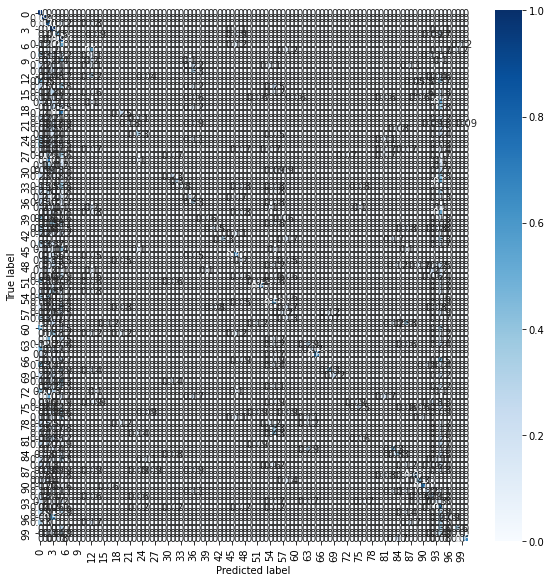

In [ ]:
plot_conf_matrix (con_mat_df)

3.2 From scratch Feature Extractor

In [ ]:
from keras import layers
base_model_2 = keras.Sequential(
    [
        keras.Input(shape=(150,150,3)),
        layers.Conv2D(32, 3, padding="valid", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(512, 4, activation="relu"),
    ]
)

In [ ]:
import numpy as np
import time
start = time.time()
train_features, train_labels = feature_extractor(CFG.train_dir, 6162,base_model=base_model_2)
print("Total time: ", time.time() - start, "seconds")


Found 6162 images belonging to 101 classes.


100%|█████████▉| 308/309 [00:47<00:00,  6.44it/s]

Total time:  48.36206817626953 seconds


In [ ]:
# validation_features, validation_labels = feature_extractor(CFG.validation_dir, 820,base_model_2)
import time
start = time.time()
test_features, test_labels = feature_extractor(CFG.test_dir, 1695,base_model_2)
print("Total time: ", time.time() - start, "seconds")


Found 1695 images belonging to 101 classes.


 99%|█████████▉| 84/85 [00:13<00:00,  6.34it/s]

Total time:  13.549534797668457 seconds


In [ ]:
train_features = np.reshape(train_features, (6162, 4 * 4 * 512))
# validation_features = np.reshape(validation_features, (820, 4 * 4 * 512))
test_features = np.reshape(test_features, (1695, 4 * 4 * 512))

In [ ]:
encoded_train_labels = label_encoder(train_labels)
encoded_test_labels = label_encoder(test_labels)
# encoded_validation_labels = label_encoder(validation_labels)

In [ ]:
from sklearn.svm import SVC
import time
start = time.time()
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(train_features,encoded_train_labels )
print("Total time: ", time.time() - start, "seconds")
svm_predictions = svm_model_linear.predict(test_features)

Total time:  466.6853621006012 seconds


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(svm_predictions, encoded_test_labels)

0.4206489675516224

Confusion matrix

In [ ]:
import pandas as pd
con_mat = tf.math.confusion_matrix(encoded_test_labels,svm_predictions).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                      index = np.unique(encoded_test_labels), 
                      columns = np.unique(encoded_test_labels))

In [ ]:
import seaborn as sns
def plot_conf_matrix (con_mat_df) : 
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

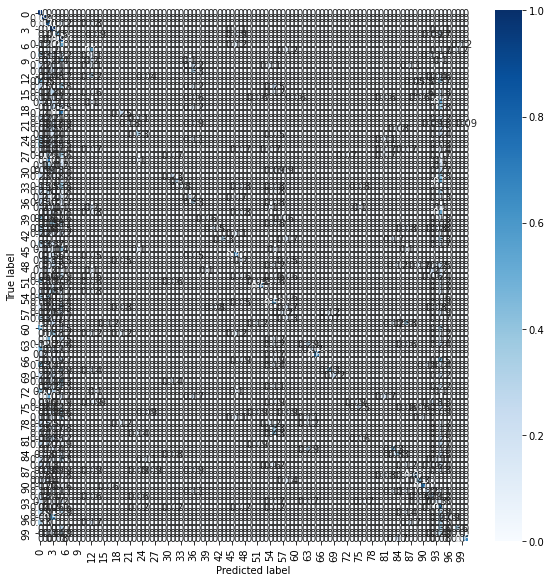

In [ ]:
import matplotlib.pyplot as plt
plot_conf_matrix (con_mat_df)